# Project Big Data Science (May 2020)

In [1]:
# Import 3rd party libraries
import tweepy
import numpy as np
import nltk
#from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
import pandas as pd

# Import our own code
from DataMiner import DataMiner
from HashtagFinder import HashtagFinder
from PreProcessTweets import PreProcessTweets
from Authentication import Authentication
from LocationService import LocationService
from Visualisation import Visualisation

# Download the Dutch stop words from the NLTK repository.
nltk.download('stopwords')

#"44.4415,-102.6855,1000km"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wannesvanleemput/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
auth = Authentication()
api = auth.get_api()

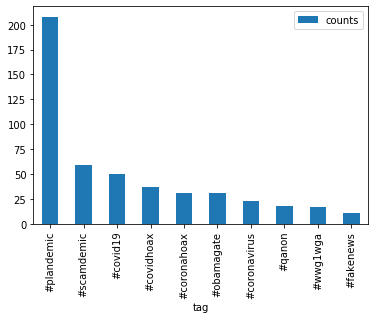

In [3]:
FILE = "#CoronaHoax.csv"

vis = Visualisation(FILE)

vis.trending_tags_global()

In [4]:
locationservice = LocationService()
df = locationservice.add_location_data(FILE)

text           520
tags           241
user           520
time           520
location       520
coordinates      8
dtype: int64


RateLimiter caught an error, retrying (0/2 tries). Called with (*('San Antonio, TX',), **{}).
Traceback (most recent call last):
  File "/Users/wannesvanleemput/opt/anaconda3/lib/python3.7/urllib/request.py", line 1319, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/Users/wannesvanleemput/opt/anaconda3/lib/python3.7/http/client.py", line 1252, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Users/wannesvanleemput/opt/anaconda3/lib/python3.7/http/client.py", line 1298, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Users/wannesvanleemput/opt/anaconda3/lib/python3.7/http/client.py", line 1247, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Users/wannesvanleemput/opt/anaconda3/lib/python3.7/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/Users/wannesvanleemput/opt/anaconda3/lib/python3.7/http/client.py", line 966, in sen

In [6]:
df.head(10)

,text,tags,user,time,location,coordinates,processed_location,point
1,Only one thing I do understand about this is t...,#Scamdemic|#ReopenAmericaNow,DeafGuyForTrump,2020-05-16 15:59:01,"Dipshit(Denver), Colorado",NaN,None,None
2,@freedompersia7 @mrfezzywig77 That’s where thi...,NaN,TiwannaRN42,2020-05-16 15:59:27,"Chicago, IL",NaN,"(Chicago, Cook County, Illinois, United States...","(41.8755616, -87.6244212, 0.0)"
3,@BreitbartNews “Rory McIlroy discusses his hur...,#nonvalueadd|#prodouche,faxoverfeelings,2020-05-16 15:59:34,"Shith Ole, CA",NaN,None,None
4,@realDonaldTrump @RandPaul @va_shiva @GovMikeD...,#TruthFreedomHealth|#Shiva4Senate|#OANN,MyraBaker528,2020-05-16 16:00:11,Cincinnati,NaN,"(Cincinnati, Hamilton County, Ohio, United Sta...","(39.1014537, -84.5124602, 0.0)"
5,#gibgateskeinechance #Plandemic #WWG1WGA #QAno...,#gibgateskeinechance|#Plandemic|#WWG1WGA|#QAno...,BeanieBee7,2020-05-16 16:00:37,"Oberhausen, Deutschland",NaN,"(Oberhausen, Nordrhein-Westfalen, 46045, Deuts...","(51.4696137, 6.8514435, 0.0)"
6,https://t.co/2Dt4gcTtO3\n\n— \nThis debunks th...,NaN,exhanny,2020-05-16 16:00:48,United Arab Emirates,NaN,"(الإمارات العربية المتحدة, (24.0002488, 53.999...","(24.0002488, 53.9994829, 0.0)"
7,@Distinct_Words @getoffmylawn60 How the fuck a...,NaN,commoncentsman,2020-05-16 16:00:55,"Georgia, USA",NaN,"(Georgia, United States of America, (32.329380...","(32.3293809, -83.1137366, 0.0)"
9,@denise4607 Doing amazing. It’s garden season ...,#QArmy|#COVID19|#Plandemic,HardwayNovember,2020-05-16 16:01:19,Up a haller,NaN,"(Am Haller, Millich, Hückelhoven, Kreis Heinsb...","(51.0633608, 6.1894453, 0.0)"
10,@Jamieson_Canada @ShopprsDrugMart why is there...,NaN,greenvaults,2020-05-16 16:01:47,Canada,NaN,"(Canada, (61.0666922, -107.9917071))","(61.0666922, -107.9917071, 0.0)"
11,#Trending The Original Plandemic: Unmasking Th...,#Trending,myprwirenews,2020-05-16 16:01:50,"Bellevue, WA",NaN,"(Bellevue, King County, Washington, United Sta...","(47.6144219, -122.1923372, 0.0)"


## Tweet data mining

We use the Tweepy.Cursor functionality to search for tweets on the coronavirus topic in a certain geographical area in the United States. We take New York City because this region has been most affected by the virus.

In [3]:
NUM_TWEETS = 5000
SEARCH_TERM = "#CovidHoax -filter:retweets"
loc = LocationService()
lat, lng = loc.get_coordinates("New York City", "United States")
location_radius = str(lat) + "," + str(lng) + ",100km"
language = "en"
starting_hashtag = "#Plandemic"
#ignore generic tags, since they could corrupt the denial-tweets dataset
tagignore = ["#Covid_19", "#coronavirus", "#COVIDー19", "#COVID19", "#coronavirusNYC", "#coronavirusoregon", "#lockdown", "#covid19", "#COVID", "#pandemic"]

In [4]:
miner = DataMiner(api, starting_hashtag, location_radius, language, tagignore)
denial_tweets = miner.mine()
print(f"Processed {len(list(denial_tweets))} tweets.")

Processing tag: #scamdemic
Processing tag: #Plandemic2020
Processing tag: #ObamaGate
Processing tag: #PlandemicDocumentary
Processing tag: #ConspiracyTheory
Processing tag: #plandemic
Processing tag: #Plandemic
Processed 2160 tweets.


In [5]:
denial_tweets.extend(miner.mine("#CoronaHoax"))

Processing tag: #COVID
Processing tag: #fakenews
Processing tag: #PLANdemic
Processing tag: #pandemic
Processing tag: #QAnon
Processing tag: #WWG1GWA
Processing tag: #DeepState
Processing tag: #COVIDIOTS
Processing tag: #Fauci
Processing tag: #qanon
Processing tag: #PLANDEMIC
Processing tag: #FauciFraud
Processing tag: #scamdemic
Processing tag: #Plandemic2020
Processing tag: #ObamaGate
Processing tag: #PlandemicDocumentary
Processing tag: #ConspiracyTheory
Processing tag: #plandemic
Processing tag: #Plandemic


In [6]:
panda = miner.get_dataframe()
panda.head()

,Author,Location,Tags
0,Nestor Delgado,"Brooklyn, New York",[#scamdemic]
1,Luna77,"New Jersey, USA",[#Scamdemic]
2,Kat,"Florida, USA","[#scamdemic, #controlaviris]"
3,Yoshi Yokamura,"New Jersey, USA","[#pizzagate, #Scamdemic]"
4,Yoshi Yokamura,"New Jersey, USA",[#scamdemic]


In [7]:
items = tweepy.Cursor(api.search,
            q="coronavirus -filter:retweets", 
            geocode="40.7282,-73.7949,1000km",
            count=100,
            lang="en",
            include_rts=False,
            tweet_mode="extended").items(NUM_TWEETS)

items = list(items)
print(f"Finished reading {len(items)} items.")
control_tweets = [t.full_text for t in items]

Finished reading 5000 items.


In [ ]:
items = tweepy.Cursor(api.search,
            q="covid -filter:retweets", 
            geocode="40.7282,-73.7949,1000km",
            count=100,
            lang="en",
            include_rts=False,
            tweet_mode="extended").items(NUM_TWEETS)

items = list(items)
print(f"Finished reading {len(items)} items.")
control_tweets.extend([t.full_text for t in items])

In [ ]:
items = tweepy.Cursor(api.search,
            q="lockdown -filter:retweets", 
            geocode="40.7282,-73.7949,1000km",
            count=100,
            lang="en",
            include_rts=False,
            tweet_mode="extended").items(NUM_TWEETS)

items = list(items)
print(f"Finished reading {len(items)} items.")
control_tweets.extend([t.full_text for t in items])

### Create a simple classification model

In [50]:
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score

In [51]:
# Do some preprocessing on the text
tweets = denial_tweets + control_tweets
preprocessor = PreProcessTweets(
                                tweets.copy(),
                                remove_tags=False,
                                remove_urls=True,
                                remove_stopwords=True,
                                remove_mentions=True
                               )
corpus = preprocessor.preprocess()
labels = [0]*len(denial_tweets) + [1]*len(control_tweets)

In [52]:
# Vectorize the input data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    labels, 
                                                    random_state=123,
                                                    test_size=0.3
                                                   )

# Train a Naive Bayes classifier
model = MultinomialNB()
model = model.fit(X_train, y_train)

# Get some performance metrics on the training set
y_predict = model.predict(X_train)

a = accuracy_score(y_train, y_predict)
p = precision_score(y_train, y_predict)
r = recall_score(y_train, y_predict)
f = f1_score(y_train, y_predict)
print("Training performance metrics: ")
print(f"\t-Accuracy: {a:.3f},\n\t-Precision: {p:.3f}, \n\t-Recall: {r:.3f},\n\t-F1: {f:.3f}")
print("="*35)

# Get some performance metrics on the test set
y_predict = model.predict(X_test)

a = accuracy_score(y_test, y_predict)
p = precision_score(y_test, y_predict)
r = recall_score(y_test, y_predict)
f = f1_score(y_test, y_predict)
print("Test performance metrics: ")
print(f"\t-Accuracy: {a:.3f},\n\t-Precision: {p:.3f}, \n\t-Recall: {r:.3f},\n\t-F1: {f:.3f}")

Training performance metrics: 
	-Accuracy: 0.975,
	-Precision: 0.978, 
	-Recall: 0.983,
	-F1: 0.981
Test performance metrics: 
	-Accuracy: 0.960,
	-Precision: 0.971, 
	-Recall: 0.967,
	-F1: 0.969


### Real-world test

We can download some more tweets from the same #CoronaHoax hashtag we started with and check that these are indeed flagged correctly as "COVID denial" tweets. The tweets now originated from Los Angeles, so there is no overlap from the training data.

In [53]:
loc = LocationService()
lat, lng = loc.get_coordinates("Los Angeles", "United States")
location = str(lat) + "," + str(lng) + ",500km"

In [72]:
items = tweepy.Cursor(api.search,
            q="coronahoax -filter:retweets", 
            geocode=location,
            count=100,
            lang="en",
            include_rts=False,
            tweet_mode="extended").items(100)

items = list(items)
print(f"Finished reading {len(items)} items.")
tweets_LA = [t.full_text for t in items]

Finished reading 74 items.


In [73]:
preprocessorLA = PreProcessTweets(
                                tweets_LA.copy(), 
                                remove_tags=False,
                                remove_urls=True,
                                remove_stopwords=True,
                                remove_mentions=True
                               )
corpus = preprocessorLA.preprocess()

In [74]:
x = vectorizer.transform(corpus)
y_predict = model.predict(x)
print(f"Accuracy: {list(y_predict).count(0) / len(y_predict):.3f}")

Accuracy: 0.824
